In [117]:
import pymongo
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

MONGO_HOST = "sectrs-vascodagama"
MONGO_PORT = 27017

ETHERSCAN_API_KEY  = "ANAZQYWNY3ZBIIMIY9P153TE6Y78PUM226"
ARBISCAN_API_KEY   = "ZR3UVYUDWUXZVHZ4FK3F5IKSP1PKYSNENF"
OPTIMISTIC_API_KEY = "MT3E76PG6K9RWD8VDTDS2R4HR7GY58QU7B"

mongo_connection = pymongo.MongoClient("mongodb://"+MONGO_HOST+":"+str(MONGO_PORT), maxPoolSize=None)

## Arbitrage

### Ethereum

Number of arbitrages on Ethereum with competition: 232074
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 14


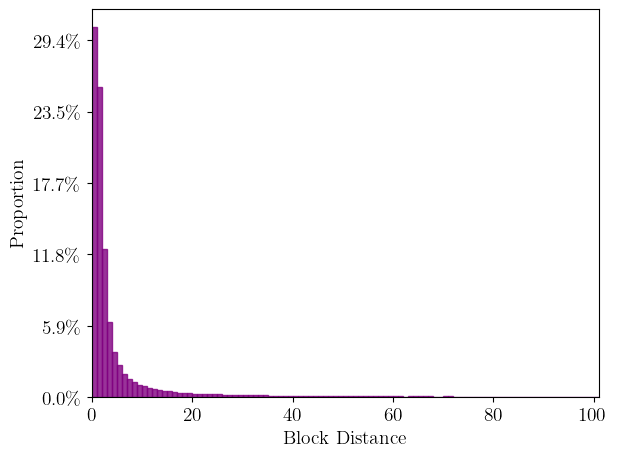

In [157]:
opportunities = list(mongo_connection["ethereum"]["mev_arbitrage_opportunities"].find())
swaps = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["swap"]["block_number"] != None:
            if not opportunity["swap"]["block_number"] in swaps:
                swaps[opportunity["swap"]["block_number"]] = set()
            swaps[opportunity["swap"]["block_number"]].add(opportunity["arbitrage"]["transaction_hash"])
                        
ethereum_arbitrage_opportunities_with_competition = list()
ethereum_arbitrage_competiton_sizes = list()
ethereum_arbitrage_competiton_distance = list()
for block_number in swaps:
    if len(swaps[block_number]) > 1:
        competitors = dict()
        for transaction_hash in swaps[block_number]:
            arbitrage = mongo_connection["ethereum"]["mev_arbitrage_results"].find_one({"transaction.hash": transaction_hash})
            if not arbitrage["transaction"]["to"] in competitors:
                competitors[arbitrage["transaction"]["to"]] = list()
            competitors[arbitrage["transaction"]["to"]].append((transaction_hash, arbitrage["block_number"]))
        if len(competitors) > 1:
            ethereum_arbitrage_opportunities_with_competition.append(competitors)
            ethereum_arbitrage_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                ethereum_arbitrage_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of arbitrages on Ethereum with competition:", len(ethereum_arbitrage_opportunities_with_competition))
if len(ethereum_arbitrage_competiton_sizes) > 0:
    print("Minimum number of competitors for a single competition:", min(ethereum_arbitrage_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(ethereum_arbitrage_competiton_sizes))
    
if len(ethereum_arbitrage_competiton_distance) > 0:
    fig, ax = plt.subplots()
    ax.hist(ethereum_arbitrage_competiton_distance, edgecolor='purple', color='purple', alpha=0.8, bins=max(ethereum_arbitrage_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(ethereum_arbitrage_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(ethereum_arbitrage_competiton_distance), max(ethereum_arbitrage_competiton_distance))
    fig.tight_layout()
    plt.show()

In [158]:
ethereum_arbitrage_zero_distance_percentage = ethereum_arbitrage_competiton_distance.count(0) / len(ethereum_arbitrage_competiton_distance) * 100.0
ethereum_arbitrage_one_distance_percentage = ethereum_arbitrage_competiton_distance.count(1) / len(ethereum_arbitrage_competiton_distance) * 100.0
print("Percentage of arbitrage competition with a block distance of 0:", ethereum_arbitrage_zero_distance_percentage)
print("Percentage of arbitrage competition with a block distance of 1:", ethereum_arbitrage_one_distance_percentage)

Percentage of arbitrage competition with a block distance of 0: 30.48071206136349
Percentage of arbitrage competition with a block distance of 1: 25.582935487099185


In [160]:
ethereum_arbitrage_competitors = set()
for competitors in ethereum_arbitrage_opportunities_with_competition:
    for competitor in competitors:
        if competitor != None:
            ethereum_arbitrage_competitors.add(competitor)
print("Number of arbitrage competitors on Ethereum:", len(ethereum_arbitrage_competitors))
failure_rate = list()
for competitor in ethereum_arbitrage_competitors:    
    response = requests.get("https://api.etherscan.io/api?module=account&action=txlist&address="+competitor+"&startblock=0&endblock=latest&page=1&offset=10000&sort=asc&apikey="+ETHERSCAN_API_KEY)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
print("Average failure rate of arbitrage competitors on Ethereum:", np.mean(failure_rate))

Number of arbitrage competitors on Ethereum: 1793
Average failure rate of arbitrage competitors on Ethereum: 7.882734791445903


### Arbitrum

Number of arbitrages on Arbitrum with competition: 259015
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 15


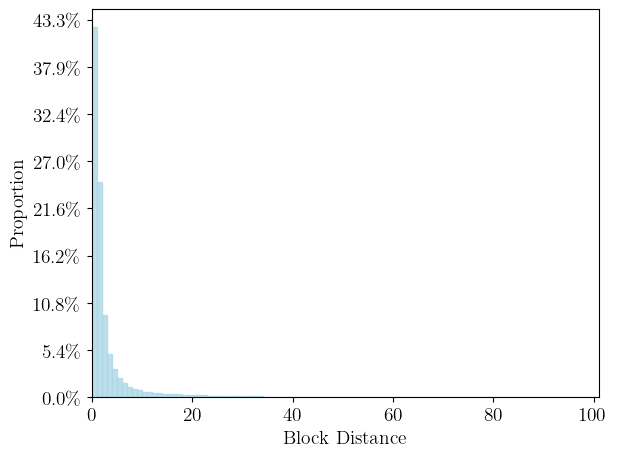

In [67]:
opportunities = list(mongo_connection["arbitrum"]["mev_arbitrage_opportunities"].find())
swaps = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["swap"]["block_number"] != None:
            if not opportunity["swap"]["block_number"] in swaps:
                swaps[opportunity["swap"]["block_number"]] = set()
            swaps[opportunity["swap"]["block_number"]].add(opportunity["arbitrage"]["transaction_hash"])
                        
arbitrum_arbitrage_opportunities_with_competition = list()
arbitrum_arbitrage_competiton_sizes = list()
arbitrum_arbitrage_competiton_distance = list()
for block_number in swaps:
    if len(swaps[block_number]) > 1:
        competitors = dict()
        for transaction_hash in swaps[block_number]:
            arbitrage = mongo_connection["arbitrum"]["mev_arbitrage_results"].find_one({"transaction.hash": transaction_hash})
            if not arbitrage["transaction"]["to"] in competitors:
                competitors[arbitrage["transaction"]["to"]] = list()
            competitors[arbitrage["transaction"]["to"]].append((transaction_hash, arbitrage["block_number"]))
        if len(competitors) > 1:
            arbitrum_arbitrage_opportunities_with_competition.append(competitors)
            arbitrum_arbitrage_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                arbitrum_arbitrage_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of arbitrages on Arbitrum with competition:", len(arbitrum_arbitrage_opportunities_with_competition))
if len(arbitrum_arbitrage_competiton_sizes) > 0:
    print("Minimum number of competitors for a single competition:", min(arbitrum_arbitrage_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(arbitrum_arbitrage_competiton_sizes))
    
if len(arbitrum_arbitrage_competiton_distance) > 0:
    fig, ax = plt.subplots()
    ax.hist(arbitrum_arbitrage_competiton_distance, edgecolor='LightBlue', color='LightBlue', alpha=0.8, bins=max(arbitrum_arbitrage_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(arbitrum_arbitrage_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(arbitrum_arbitrage_competiton_distance), max(arbitrum_arbitrage_competiton_distance))
    fig.tight_layout()
    plt.show()

In [129]:
arbitrum_arbitrage_zero_distance_percentage = arbitrum_arbitrage_competiton_distance.count(0) / len(arbitrum_arbitrage_competiton_distance) * 100.0
arbitrum_arbitrage_one_distance_percentage = arbitrum_arbitrage_competiton_distance.count(1) / len(arbitrum_arbitrage_competiton_distance) * 100.0
print("Percentage of arbitrage competition with a block distance of 0:", arbitrum_arbitrage_zero_distance_percentage)
print("Percentage of arbitrage competition with a block distance of 1:", arbitrum_arbitrage_one_distance_percentage)

Percentage of arbitrage competition with a block distance of 0: 42.34734294945453
Percentage of arbitrage competition with a block distance of 1: 24.67657118137699


In [149]:
arbitrum_arbitrage_competitors = set()
for competitors in arbitrum_arbitrage_opportunities_with_competition:
    for competitor in competitors:
        if competitor != None:
            arbitrum_arbitrage_competitors.add(competitor)
print("Number of arbitrage competitors on Arbitrum:", len(arbitrum_arbitrage_competitors))
failure_rate = list()
for competitor in arbitrum_arbitrage_competitors:
    response = requests.get("https://api.arbiscan.io/api?module=account&action=txlist&address="+competitor+"&startblock=0&endblock=latest&page=1&offset=10000&sort=asc&apikey="+ARBISCAN_API_KEY)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
if len(failure_rate) > 0:
    print("Average failure rate of arbitrage competitors on Arbitrum:", np.mean(failure_rate))

Number of arbitrage competitors on Arbitrum: 989
Average failure rate of arbitrage competitors on Arbitrum: 38.88641116193465


### Optimism

Number of arbitrages on Optimism with competition: 156590
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 9


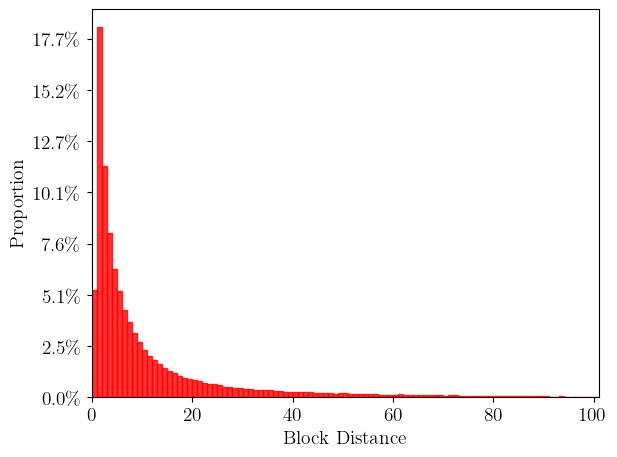

In [150]:
opportunities = list(mongo_connection["optimism"]["mev_arbitrage_opportunities"].find())
swaps = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["swap"]["block_number"] != None:
            if not opportunity["swap"]["block_number"] in swaps:
                swaps[opportunity["swap"]["block_number"]] = set()
            swaps[opportunity["swap"]["block_number"]].add(opportunity["arbitrage"]["transaction_hash"])
                        
optimism_arbitrage_opportunities_with_competition = list()
optimism_arbitrage_competiton_sizes = list()
optimism_arbitrage_competiton_distance = list()
for block_number in swaps:
    if len(swaps[block_number]) > 1:
        competitors = dict()
        for transaction_hash in swaps[block_number]:
            arbitrage = mongo_connection["optimism"]["mev_arbitrage_results"].find_one({"transaction.hash": transaction_hash})
            if not arbitrage["transaction"]["to"] in competitors:
                competitors[arbitrage["transaction"]["to"]] = list()
            competitors[arbitrage["transaction"]["to"]].append((transaction_hash, arbitrage["block_number"]))
        if len(competitors) > 1:
            optimism_arbitrage_opportunities_with_competition.append(competitors)
            optimism_arbitrage_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                optimism_arbitrage_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of arbitrages on Optimism with competition:", len(optimism_arbitrage_opportunities_with_competition))
if len(optimism_arbitrage_competiton_sizes) > 0:
    print("Minimum number of competitors for a single competition:", min(optimism_arbitrage_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(optimism_arbitrage_competiton_sizes))
    
if len(optimism_arbitrage_competiton_distance) > 0:
    fig, ax = plt.subplots()
    ax.hist(optimism_arbitrage_competiton_distance, edgecolor='red', color='red', alpha=0.8, bins=max(optimism_arbitrage_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(optimism_arbitrage_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(optimism_arbitrage_competiton_distance), max(optimism_arbitrage_competiton_distance))
    fig.tight_layout()
    plt.show()

In [151]:
optimism_arbitrage_zero_distance_percentage = optimism_arbitrage_competiton_distance.count(0) / len(optimism_arbitrage_competiton_distance) * 100.0
optimism_arbitrage_one_distance_percentage = optimism_arbitrage_competiton_distance.count(1) / len(optimism_arbitrage_competiton_distance) * 100.0
print("Percentage of arbitrage competition with a block distance of 0:", optimism_arbitrage_zero_distance_percentage)
print("Percentage of arbitrage competition with a block distance of 1:", optimism_arbitrage_one_distance_percentage)

Percentage of arbitrage competition with a block distance of 0: 5.297949458849771
Percentage of arbitrage competition with a block distance of 1: 18.294679745519986


In [156]:
optimism_arbitrage_competitors = set()
for competitors in optimism_arbitrage_opportunities_with_competition:
    for competitor in competitors:
        if competitor != None:
            optimism_arbitrage_competitors.add(competitor)
print("Number of arbitrage competitors on optimism:", len(optimism_arbitrage_competitors))
failure_rate = list()
for competitor in optimism_arbitrage_competitors:
    response = requests.get("https://api-optimistic.etherscan.io/api?module=account&action=txlist&address="+competitor+"&startblock=0&endblock=latest&page=1&offset=10000&sort=asc&apikey="+OPTIMISTIC_API_KEY)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
if len(failure_rate) > 0:
    print("Average failure rate of arbitrage competitors on optimism:", np.mean(failure_rate))

Number of arbitrage competitors on optimism: 505
Average failure rate of arbitrage competitors on optimism: 29.27933030451606


### zkSync

Number of arbitrages on zkSync with competition: 4302
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 7


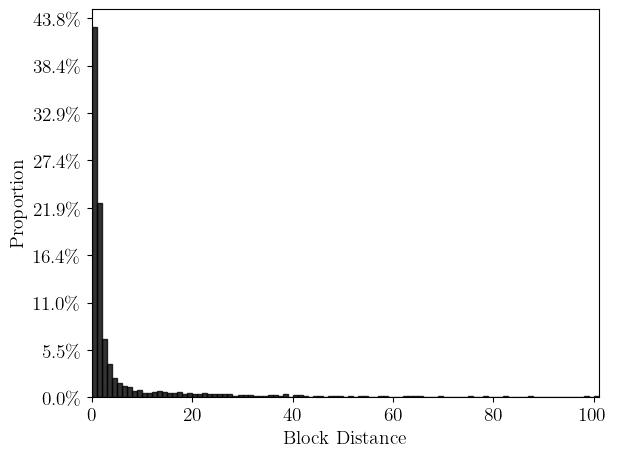

In [65]:
opportunities = list(mongo_connection["zksync"]["mev_arbitrage_opportunities"].find())
swaps = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["swap"]["block_number"] != None:
            if not opportunity["swap"]["block_number"] in swaps:
                swaps[opportunity["swap"]["block_number"]] = set()
            swaps[opportunity["swap"]["block_number"]].add(opportunity["arbitrage"]["transaction_hash"])
                        
zksync_arbitrage_opportunities_with_competition = list()
zksync_arbitrage_competiton_sizes = list()
zksync_arbitrage_competiton_distance = list()
for block_number in swaps:
    if len(swaps[block_number]) > 1:
        competitors = dict()
        for transaction_hash in swaps[block_number]:
            arbitrage = mongo_connection["zksync"]["mev_arbitrage_results"].find_one({"transaction.hash": transaction_hash})
            if not arbitrage["transaction"]["to"] in competitors:
                competitors[arbitrage["transaction"]["to"]] = list()
            competitors[arbitrage["transaction"]["to"]].append((transaction_hash, arbitrage["block_number"]))
        if len(competitors) > 1:
            zksync_arbitrage_opportunities_with_competition.append(competitors)
            zksync_arbitrage_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                zksync_arbitrage_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of arbitrages on zkSync with competition:", len(zksync_arbitrage_opportunities_with_competition))
if len(zksync_arbitrage_competiton_sizes) > 0:
    print("Minimum number of competitors for a single competition:", min(zksync_arbitrage_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(zksync_arbitrage_competiton_sizes))
    
if len(zksync_arbitrage_competiton_distance) > 0:
    fig, ax = plt.subplots()
    ax.hist(zksync_arbitrage_competiton_distance, edgecolor='black', color='black', alpha=0.8, bins=max(zksync_arbitrage_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(zksync_arbitrage_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(zksync_arbitrage_competiton_distance), max(zksync_arbitrage_competiton_distance))
    fig.tight_layout()
    plt.show()

In [140]:
zksync_arbitrage_zero_distance_percentage = 0
zksync_arbitrage_one_distance_percentage = 0
if len(zksync_arbitrage_competiton_distance):
    zksync_arbitrage_zero_distance_percentage = zksync_arbitrage_competiton_distance.count(0) / len(zksync_arbitrage_competiton_distance) * 100.0
    zksync_arbitrage_one_distance_percentage = zksync_arbitrage_competiton_distance.count(1) / len(zksync_arbitrage_competiton_distance) * 100.0
print("Percentage of arbitrage competition with a block distance of 0:", zksync_arbitrage_zero_distance_percentage)
print("Percentage of arbitrage competition with a block distance of 1:", zksync_arbitrage_one_distance_percentage)

Percentage of arbitrage competition with a block distance of 0: 42.76633055677335
Percentage of arbitrage competition with a block distance of 1: 22.42437527400263


In [141]:
zksync_arbitrage_competitors = set()
for competitors in zksync_arbitrage_opportunities_with_competition:
    for competitor in competitors:
        zksync_arbitrage_competitors.add(competitor)
print("Number of arbitrage competitors on zkSync:", len(zksync_arbitrage_competitors))
failure_rate = list()
for competitor in zksync_arbitrage_competitors:    
    response = requests.get("https://block-explorer-api.mainnet.zksync.io/api?module=account&action=txlist&page=1&offset=1000&sort=asc&endblock=latest&startblock=0&address="+competitor)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
if len(failure_rate) > 0:
    print("Average failure rate of arbitrage competitors on zkSync:", np.mean(failure_rate))

Number of arbitrage competitors on zkSync: 90
Average failure rate of arbitrage competitors on zkSync: 38.32997910060881


## Liquidation

### Ethereum

Number of liquidations on Ethereum with competition: 2782
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 10


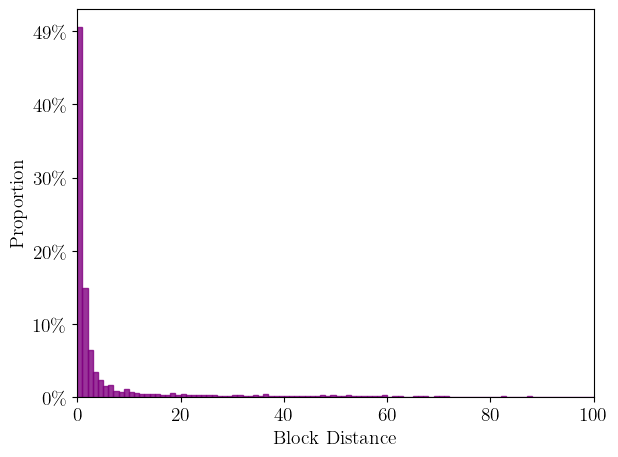

In [63]:
opportunities = list(mongo_connection["ethereum"]["mev_liquidation_opportunities"].find())
oracle_updates = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["oracle_update"]["block_number"] != None:
            if not opportunity["oracle_update"]["block_number"] in oracle_updates:
                oracle_updates[opportunity["oracle_update"]["block_number"]] = set()
            oracle_updates[opportunity["oracle_update"]["block_number"]].add(opportunity["liquidation"]["transaction_hash"])

ethereum_liquidation_opportunities_with_competition = list()
ethereum_liquidation_competiton_sizes = list()
ethereum_liquidation_competiton_distance = list()
for block_number in oracle_updates:
    if len(oracle_updates[block_number]) > 1:
        competitors = dict()
        for transaction_hash in oracle_updates[block_number]:
            liquidation = mongo_connection["ethereum"]["mev_liquidation_results"].find_one({"transaction.hash": transaction_hash})
            if not liquidation["transaction"]["to"] in competitors:
                competitors[liquidation["transaction"]["to"]] = list()
            competitors[liquidation["transaction"]["to"]].append((transaction_hash, liquidation["block_number"]))
        if len(competitors) > 1:
            ethereum_liquidation_opportunities_with_competition.append(competitors)
            ethereum_liquidation_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                ethereum_liquidation_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of liquidations on Ethereum with competition:", len(ethereum_liquidation_opportunities_with_competition))
if optimism_liquidation_competiton_sizes:
    print("Minimum number of competitors for a single competition:", min(ethereum_liquidation_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(ethereum_liquidation_competiton_sizes))

if ethereum_liquidation_competiton_distance:
    fig, ax = plt.subplots()
    ax.hist(ethereum_liquidation_competiton_distance, edgecolor='purple', color='purple', alpha=0.8, bins=max(ethereum_liquidation_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(ethereum_liquidation_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(ethereum_liquidation_competiton_distance), max(ethereum_liquidation_competiton_distance))
    fig.tight_layout()
    plt.show()

In [139]:
ethereum_liquidation_zero_distance_percentage = 0
ethereum_liquidation_one_distance_percentage = 0
if len(ethereum_liquidation_competiton_distance):
    ethereum_liquidation_zero_distance_percentage = ethereum_liquidation_competiton_distance.count(0) / len(ethereum_liquidation_competiton_distance) * 100.0
    ethereum_liquidation_one_distance_percentage = ethereum_liquidation_competiton_distance.count(1) / len(ethereum_liquidation_competiton_distance) * 100.0
print("Percentage of liquidation competition with a block distance of 0:", ethereum_liquidation_zero_distance_percentage)
print("Percentage of liquidation competition with a block distance of 1:", ethereum_liquidation_one_distance_percentage)

Percentage of liquidation competition with a block distance of 0: 49.95052444092618
Percentage of liquidation competition with a block distance of 1: 14.723926380368098


In [119]:
ethereum_liquidation_competitors = set()
for competitors in ethereum_liquidation_opportunities_with_competition:
    for competitor in competitors:
        ethereum_liquidation_competitors.add(competitor)
print("Number of liquidation competitors on Ethereum:", len(ethereum_liquidation_competitors))
failure_rate = list()
for competitor in ethereum_liquidation_competitors:    
    response = requests.get("https://api.etherscan.io/api?module=account&action=txlist&address="+competitor+"&startblock=0&endblock=latest&page=1&offset=10000&sort=asc&apikey="+ETHERSCAN_API_KEY)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
print("Average failure rate of liquidation competitors on Ethereum:", np.mean(failure_rate))

Number of liquidation competitors on Ethereum: 309
Average failure rate of liquidation competitors on Ethereum: 16.78011114301525


### Arbitrum

Number of liquidations on Arbitrum with competition: 120
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 5


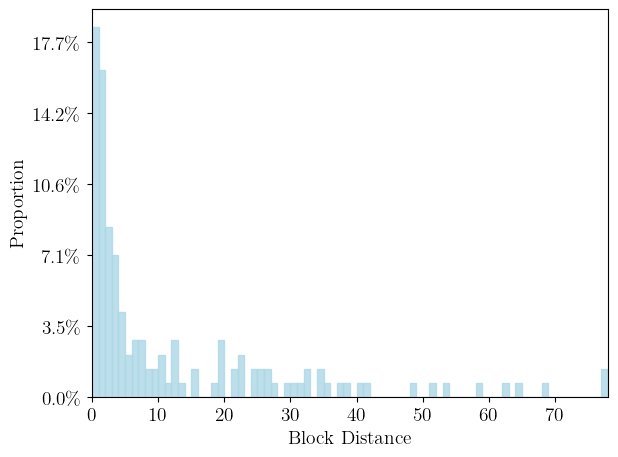

In [61]:
opportunities = list(mongo_connection["arbitrum"]["mev_liquidation_opportunities"].find())
oracle_updates = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["oracle_update"]["block_number"] != None:
            if not opportunity["oracle_update"]["block_number"] in oracle_updates:
                oracle_updates[opportunity["oracle_update"]["block_number"]] = set()
            oracle_updates[opportunity["oracle_update"]["block_number"]].add(opportunity["liquidation"]["transaction_hash"])

arbitrum_liquidation_opportunities_with_competition = list()
arbitrum_liquidation_competiton_sizes = list()
arbitrum_liquidation_competiton_distance = list()
for block_number in oracle_updates:
    if len(oracle_updates[block_number]) > 1:
        competitors = dict()
        for transaction_hash in oracle_updates[block_number]:
            liquidation = mongo_connection["arbitrum"]["mev_liquidation_results"].find_one({"transaction.hash": transaction_hash})
            if not liquidation["transaction"]["to"] in competitors:
                competitors[liquidation["transaction"]["to"]] = list()
            competitors[liquidation["transaction"]["to"]].append((transaction_hash, liquidation["block_number"]))
        if len(competitors) > 1:
            arbitrum_liquidation_opportunities_with_competition.append(competitors)
            arbitrum_liquidation_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                arbitrum_liquidation_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of liquidations on Arbitrum with competition:", len(arbitrum_liquidation_opportunities_with_competition))
if optimism_liquidation_competiton_sizes:
    print("Minimum number of competitors for a single competition:", min(arbitrum_liquidation_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(arbitrum_liquidation_competiton_sizes))

if arbitrum_liquidation_competiton_distance:
    fig, ax = plt.subplots()
    ax.hist(arbitrum_liquidation_competiton_distance, edgecolor='LightBlue', color='LightBlue', alpha=0.8, bins=max(arbitrum_liquidation_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(arbitrum_liquidation_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(arbitrum_liquidation_competiton_distance), max(arbitrum_liquidation_competiton_distance))
    fig.tight_layout()
    plt.show()

In [138]:
arbitrum_liquidation_zero_distance_percentage = 0
arbitrum_liquidation_one_distance_percentage = 0
if len(arbitrum_liquidation_competiton_distance):
    arbitrum_liquidation_zero_distance_percentage = arbitrum_liquidation_competiton_distance.count(0) / len(arbitrum_liquidation_competiton_distance) * 100.0
    arbitrum_liquidation_one_distance_percentage = arbitrum_liquidation_competiton_distance.count(1) / len(arbitrum_liquidation_competiton_distance) * 100.0
print("Percentage of liquidation competition with a block distance of 0:", arbitrum_liquidation_zero_distance_percentage)
print("Percentage of liquidation competition with a block distance of 1:", arbitrum_liquidation_one_distance_percentage)

Percentage of liquidation competition with a block distance of 0: 18.439716312056735
Percentage of liquidation competition with a block distance of 1: 16.312056737588655


In [124]:
arbitrum_liquidation_competitors = set()
for competitors in arbitrum_liquidation_opportunities_with_competition:
    for competitor in competitors:
        arbitrum_liquidation_competitors.add(competitor)
print("Number of liquidation competitors on Arbitrum:", len(arbitrum_liquidation_competitors))
failure_rate = list()
for competitor in arbitrum_liquidation_competitors:    
    response = requests.get("https://api.arbiscan.io/api?module=account&action=txlist&address="+competitor+"&startblock=0&endblock=latest&page=1&offset=10000&sort=asc&apikey="+ARBISCAN_API_KEY)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
if len(failure_rate) > 0:
    print("Average failure rate of liquidation competitors on Arbitrum:", np.mean(failure_rate))

Number of liquidation competitors on Arbitrum: 40
Average failure rate of liquidation competitors on Arbitrum: 28.831711879807678


### Optimism

Number of liquidations on Optimism with competition: 123
Minimum number of competitors for a single competition: 2
Maximum number of competitors for a single competition: 5


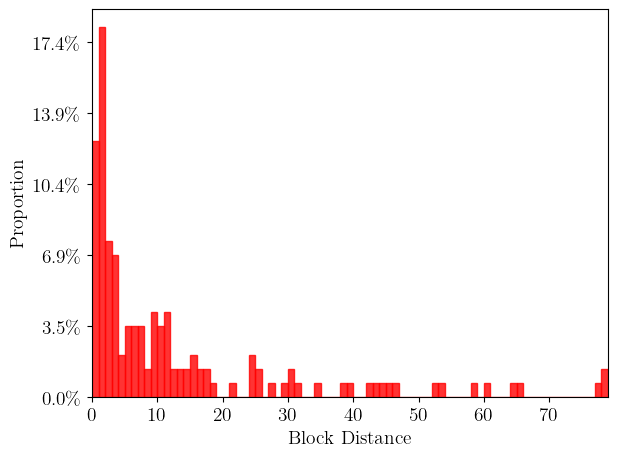

In [60]:
opportunities = list(mongo_connection["optimism"]["mev_liquidation_opportunities"].find())
oracle_updates = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["oracle_update"]["block_number"] != None:
            if not opportunity["oracle_update"]["block_number"] in oracle_updates:
                oracle_updates[opportunity["oracle_update"]["block_number"]] = set()
            oracle_updates[opportunity["oracle_update"]["block_number"]].add(opportunity["liquidation"]["transaction_hash"])

optimism_liquidation_opportunities_with_competition = list()
optimism_liquidation_competiton_sizes = list()
optimism_liquidation_competiton_distance = list()
for block_number in oracle_updates:
    if len(oracle_updates[block_number]) > 1:
        competitors = dict()
        for transaction_hash in oracle_updates[block_number]:
            liquidation = mongo_connection["optimism"]["mev_liquidation_results"].find_one({"transaction.hash": transaction_hash})
            if not liquidation["transaction"]["to"] in competitors:
                competitors[liquidation["transaction"]["to"]] = list()
            competitors[liquidation["transaction"]["to"]].append((transaction_hash, liquidation["block_number"]))
        if len(competitors) > 1:
            optimism_liquidation_opportunities_with_competition.append(competitors)
            optimism_liquidation_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                optimism_liquidation_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of liquidations on Optimism with competition:", len(optimism_liquidation_opportunities_with_competition))
if len(optimism_liquidation_competiton_sizes) > 0:
    print("Minimum number of competitors for a single competition:", min(optimism_liquidation_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(optimism_liquidation_competiton_sizes))
    
if len(optimism_liquidation_competiton_distance) > 0:
    fig, ax = plt.subplots()
    ax.hist(optimism_liquidation_competiton_distance, edgecolor='red', color='red', alpha=0.8, bins=max(optimism_liquidation_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(optimism_liquidation_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(optimism_liquidation_competiton_distance), max(optimism_liquidation_competiton_distance))
    fig.tight_layout()
    plt.show()

In [137]:
optimism_liquidation_zero_distance_percentage = 0
optimism_liquidation_one_distance_percentage = 0
if len(optimism_liquidation_competiton_distance):
    optimism_liquidation_zero_distance_percentage = optimism_liquidation_competiton_distance.count(0) / len(optimism_liquidation_competiton_distance) * 100.0
    optimism_liquidation_one_distance_percentage = optimism_liquidation_competiton_distance.count(1) / len(optimism_liquidation_competiton_distance) * 100.0
print("Percentage of liquidation competition with a block distance of 0:", optimism_liquidation_zero_distance_percentage)
print("Percentage of liquidation competition with a block distance of 1:", optimism_liquidation_one_distance_percentage)

Percentage of liquidation competition with a block distance of 0: 12.5
Percentage of liquidation competition with a block distance of 1: 18.055555555555554


In [126]:
optimism_liquidation_competitors = set()
for competitors in optimism_liquidation_opportunities_with_competition:
    for competitor in competitors:
        optimism_liquidation_competitors.add(competitor)
print("Number of liquidation competitors on Optimism:", len(optimism_liquidation_competitors))
failure_rate = list()
for competitor in optimism_liquidation_competitors:    
    response = requests.get("https://api-optimistic.etherscan.io/api?module=account&action=txlist&address="+competitor+"&startblock=0&endblock=latest&page=1&offset=10000&sort=asc&apikey="+OPTIMISTIC_API_KEY)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
if len(failure_rate) > 0:
    print("Average failure rate of liquidation competitors on Optimism:", np.mean(failure_rate))

Number of liquidation competitors on Optimism: 40
Average failure rate of liquidation competitors on Optimism: 27.419705647494016


### zkSync

In [58]:
opportunities = list(mongo_connection["zksync"]["mev_liquidation_opportunities"].find())
oracle_updates = dict()
for i in range(len(opportunities)):
    for opportunity in opportunities[i]["opportunities"]:
        if opportunity["oracle_update"]["block_number"] != None:
            if not opportunity["oracle_update"]["block_number"] in oracle_updates:
                oracle_updates[opportunity["oracle_update"]["block_number"]] = set()
            oracle_updates[opportunity["oracle_update"]["block_number"]].add(opportunity["liquidation"]["transaction_hash"])
                        
zksync_liquidation_opportunities_with_competition = list()
zksync_liquidation_competiton_sizes = list()
zksync_liquidation_competiton_distance = list()
for block_number in oracle_updates:
    if len(oracle_updates[block_number]) > 1:
        competitors = dict()
        for transaction_hash in oracle_updates[block_number]:
            liquidation = mongo_connection["zksync"]["mev_liquidation_results"].find_one({"transaction.hash": transaction_hash})
            if not liquidation["transaction"]["to"] in competitors:
                competitors[liquidation["transaction"]["to"]] = list()
            competitors[liquidation["transaction"]["to"]].append((transaction_hash, liquidation["block_number"]))
        if len(competitors) > 1:
            zksync_liquidation_opportunities_with_competition.append(competitors)
            zksync_liquidation_competiton_sizes.append(len(competitors))
            distances = list()
            for competitor in competitors:
                distances.append(min([number for _, number in competitors[competitor]]))
            distances.sort()
            first_block = distances[0]
            for i in range(len(distances)-1):
                zksync_liquidation_competiton_distance.append(distances[i+1] - first_block) 
                
print("Number of liquidations on zkSync with competition:", len(zksync_liquidation_opportunities_with_competition))
if len(zksync_liquidation_competiton_sizes) > 0:
    print("Minimum number of competitors for a single competition:", min(zksync_liquidation_competiton_sizes))
    print("Maximum number of competitors for a single competition:", max(zksync_liquidation_competiton_sizes))
    
if len(zksync_liquidation_competiton_distance) > 0:
    fig, ax = plt.subplots()
    ax.hist(zksync_liquidation_competiton_distance, edgecolor='black', color='black', alpha=0.8, bins=max(zksync_liquidation_competiton_distance))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(len(zksync_liquidation_competiton_distance)))
    ax.set_xlabel('Block Distance')
    ax.set_ylabel('Proportion')
    ax.set_xlim(min(zksync_liquidation_competiton_distance), max(zksync_liquidation_competiton_distance))
    fig.tight_layout()
    plt.show()

Number of liquidations on zkSync with competition: 0


In [136]:
zksync_liquidation_zero_distance_percentage = 0
zksync_liquidation_one_distance_percentage = 0
if len(zksync_liquidation_competiton_distance):
    zksync_liquidation_zero_distance_percentage = zksync_liquidation_competiton_distance.count(0) / len(zksync_liquidation_competiton_distance) * 100.0
    zksync_liquidation_one_distance_percentage = zksync_liquidation_competiton_distance.count(1) / len(zksync_liquidation_competiton_distance) * 100.0
print("Percentage of liquidation competition with a block distance of 0:", zksync_liquidation_zero_distance_percentage)
print("Percentage of liquidation competition with a block distance of 1:", zksync_liquidation_one_distance_percentage)

Percentage of liquidation competition with a block distance of 0: 0
Percentage of liquidation competition with a block distance of 1: 0


In [133]:
zksync_liquidation_competitors = set()
for competitors in zksync_liquidation_opportunities_with_competition:
    for competitor in competitors:
        zksync_liquidation_competitors.add(competitor)
print("Number of liquidation competitors on zkSync:", len(zksync_liquidation_competitors))
failure_rate = list()
for competitor in zksync_liquidation_competitors:    
    response = requests.get("https://block-explorer-api.mainnet.zksync.io/api?module=account&action=txlist&page=1&offset=1000&sort=asc&endblock=latest&startblock=0&address="+competitor)
    successful, failed = 0, 0
    for tx in response.json()["result"]:
        if tx["txreceipt_status"] == "1":
            successful += 1
        else:
            failed += 1
    if len(response.json()["result"]) > 0:
        failure_rate.append(failed / len(response.json()["result"]) * 100.0)
    else:
        failure_rate.append(0.0)
if len(failure_rate) > 0:
    print("Average failure rate of liquidation competitors on zkSync:", np.mean(failure_rate))

Number of liquidation competitors on zkSync: 0
